## Flow Segmentation

<p>
  <a target="_blank" href="https://colab.research.google.com/github/AliRKhojasteh/Flow_segmentation/blob/main/Notebooks/Flow_segmentation.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" height="30"/>
  </a>

  <a target="_blank" href="https://github.com/AliRKhojasteh/Flow_segmentation/Notebooks/Flow_segmentation">
    <img src="https://img.shields.io/badge/-View%20on%20GitHub-blue?logo=github" alt="View on GitHub" height="30"/>
  </a>

  <a target="_blank" href="https://github.com/AliRKhojasteh/Flow_segmentation/Docs/tutorials.md">
    <img src="https://img.shields.io/badge/-View%20Documentation-blue?logo=read-the-docs" alt="View Documentation" height="30"/>
  </a>
</p>

## 1_ Read dependencies and install them

In [3]:
import os
import sys
import subprocess

repos = {
    "segment-anything": "https://github.com/facebookresearch/segment-anything.git",
    "GroundingDINO": "https://github.com/IDEA-Research/GroundingDINO.git",
    "supervision": "https://github.com/roboflow/supervision.git"
}

# If running in Google Colab, add the Flow_segmentation repository
try:
    import google.colab
    repos["Flow_segmentation"] = "https://github.com/AliRKhojasteh/Flow_segmentation.git"
except ImportError:
    pass

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
scripts_dir = os.path.join(parent_dir, 'Scripts', 'libs')

sys.path.append(os.path.dirname(scripts_dir))

os.makedirs(scripts_dir, exist_ok=True)

for repo_name, repo_url in repos.items():
    repo_path = os.path.join(scripts_dir, repo_name)

    if os.path.isdir(repo_path):
        print(f"Pulling the latest version of {repo_name}...")
        subprocess.run(['git', 'pull'], cwd=repo_path, check=True)
    else:
        print(f"Cloning the repository {repo_name}...")
        subprocess.run(['git', 'clone', repo_url, repo_path], check=True)

    sys.path.append(repo_path)

    # Install the dependencies
    requirements_path = os.path.join(repo_path, 'requirements.txt')
    if os.path.isfile(requirements_path):
        print(f"Installing dependencies for {repo_name}...")
        subprocess.run(['pip', 'install', '-r', requirements_path], check=True)


try:
    import google.colab
    parent_dir = os.path.join(scripts_dir, "Flow_segmentation")
except ImportError:
    parent_dir = os.path.dirname(os.getcwd())

scripts_dir = os.path.join(parent_dir, "Scripts")
sys.path.append(scripts_dir)

Pulling the latest version of segment-anything...
Pulling the latest version of GroundingDINO...
Pulling the latest version of supervision...


## 2_ Loading the Input Image: Recommendations for Optimal Model Performance

1. **Format and Channels:** Ensure the image is in PNG format and utilizes three channels (RGB).
2. **Invert colors:** Consider inverting the image colors
2. **Colors:** Try different color maps.
3. **Image Pre-processing:** Additional pre-processing steps such as sharpening might be beneficial.

All examples available in the 'demo' directory are permitted for demonstration purposes only. For additional usage permissions, please contact the corresponding authors listed in the references.


For instructions on how to read and mask **DAVIS .im7** images, please refer to the [Mask_im7_files.ipynb](https://github.com/AliRKhojasteh/Flow_segmentation/blob/main/Notebooks/Mask_im7_files.ipynb).

Text input: Fingers and a hand


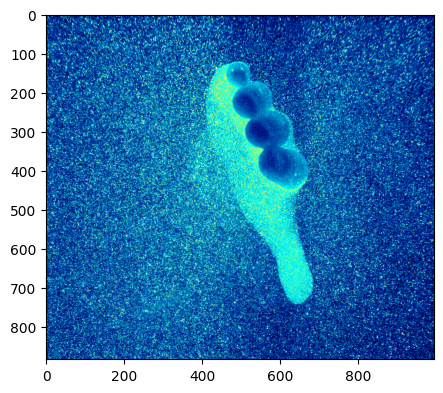

In [10]:
import os
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

###### Change the text prompt here ######
text_prompt = 'Fingers and a hand'
print("Text input:", text_prompt)
#########################################

image_path = os.path.join(parent_dir, "Demo", "Fingers.png")
image_pil = Image.open(image_path).convert("RGB")

plt.figure(figsize=(5, 5))
plt.imshow(image_pil)
plt.show()

image_pil = ImageOps.invert(image_pil)

<font color='red'>**Only for**</font> manually uploading your file in Colab. Otherwise, skip this cell!

Does not work on the <font color='red'>**Safari browser!**</font>

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps

###### Change the text prompt here ######
text_prompt = 'Cylinder'
print("Text input:", text_prompt)
#########################################

try:
    # Try to import google.colab,
    # Step 1: Upload an image with the browse button
    # Step 2: Upload the image and show imshow

    from google.colab import files
    uploaded = files.upload()
    image_path = []
    for filename in uploaded.keys():

        # Save the file with its original filename
        uploaded_filename = list(uploaded.keys())[0]
        with open(uploaded_filename, 'wb') as f:
            f.write(uploaded[uploaded_filename])

        img = mpimg.imread(uploaded_filename)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Add the path of the uploaded image to the list
        # image_path.append(os.path.join(os.getcwd(), uploaded_filename))
        # image_pil = Image.open(image_path[0]).convert("RGB")
        image_path = os.path.join(os.getcwd(), list(uploaded.keys())[0])
        image_pil = Image.open(image_path).convert("RGB")        

except ImportError:
    image_path = os.path.join(parent_dir, "Demo", "Fingers.png")
    image_pil = Image.open(image_path).convert("RGB")
    image_pil = ImageOps.invert(image_pil) # if necessary


## 3_ Mask Computation

1. **Select the size of the pre-trained Vision Transformer (ViT) model:**

    - **vit_b** = "base"  # Base-sized model
    - **vit_l** = "large"  # Large-sized model
    - **vit_h** = "huge"  # Huge-sized model

2. **Computation Device:** cpu or cuda
3. **Language Model = bert-base-uncased**

Device: cuda
final text_encoder_type: bert-base-uncased
Check the latest .pth from: https://github.com/IDEA-Research/GroundingDINO/releases


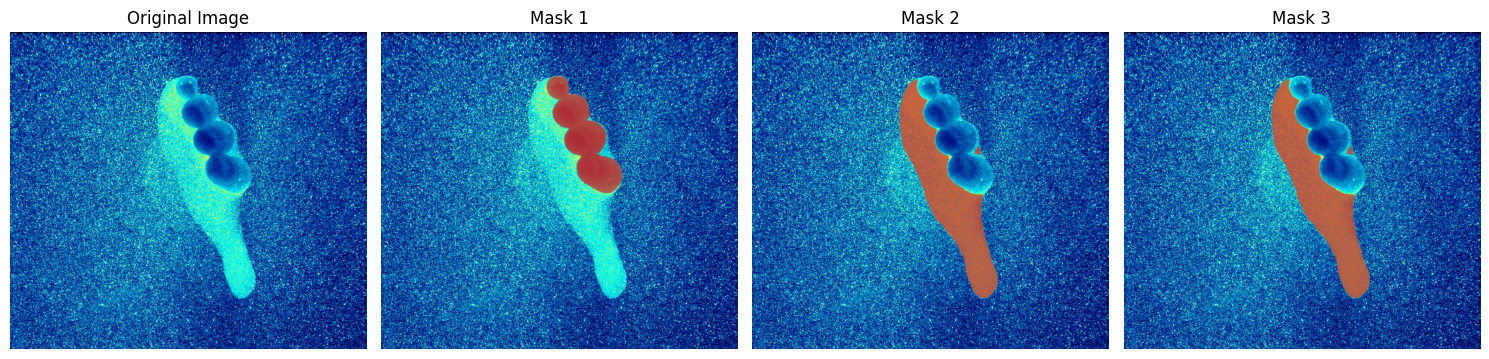

In [11]:
import torch
import numpy as np
from Flow_segmentation import Superimpose_image_with_masks, Predictor, Groundingdino_model, Segmentation_model

######################### vit model type ##########################
sam_type="vit_h" # "vit_b" or "vit_l"

######### Auxiliary box in case text prompt does not work #########
aux_box = torch.tensor([[0, 200, 1200, 400]])  # Replace with your auxiliary box in pixels x y w h

######### Point where you want to mask '1' or unmask '0' #########
input_point = None #np.array([[0, 100], [100, 450]]) # coordinates in pixels
input_label = None #np.array([0, 1]) # 1 for mask, 0 for unmask
###################################################################

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

groundingdino_model = Groundingdino_model()
sam_model = Segmentation_model(sam_type, ckpt_path=None, device=device)

masks, boxes, phrases, logits = Predictor(image_pil, text_prompt, input_point, input_label, groundingdino_model, sam_model, aux_box, box_threshold=0.3, text_threshold=0.25)

image_pil = ImageOps.invert(image_pil) # if necessary

if len(masks) == 0:
    print(f"No objects of the '{text_prompt}' prompt detected in the image.")
else:
    # Convert masks to numpy arrays
    masks_np = [mask.squeeze().cpu().numpy() for mask in masks]

    Superimpose_image_with_masks(image_pil, masks_np)


## 4_ Save Masks
- **npy**: Save in .npy, a binary format for storing NumPy arrays.
- **mat**: Save in .mat, storing **MATLAB** arrays.
- **png**: Save as .png,
- **txt**: Save in .txt,

In [ ]:
import os
from Save_masks import save_masks_to_file

# Get the directory and base name of the file
save_dir = os.path.dirname(image_path)
save_name = os.path.splitext(os.path.basename(image_path))[0]
format = 'mat' # 'npy', 'mat', 'png', or 'txt'

save_masks_to_file(masks, save_dir, save_name, format)